## Analyze GSV Downloads & Street Segments

###  Set up

In [17]:
import os
import sys
import re
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import json
import numpy as np

# Set up dirs for jupyter notebook using cwd
dir_name = 'PGHComputerVision'
root = os.getcwd()
# sub out any text after dir_name to get project directory
root = re.sub(rf"{dir_name}.*", dir_name, root)

# create code and data directories
code_root = os.path.join(root, 'Code')
data_root = os.path.join(root, 'Data')

# Read in helper function
sys.path.append( os.path.join(code_root, 'helpers') )
from read_in_PGH_shp_files import load_pgh_shp_files

## Set default EPSG/CRS
Pennsylvania South (EPSG: 32129): More appropriate for the southern part, including Pittsburgh.

In [18]:
EPSG_dict = {
    'epsg': 32129}

## Read in Image Metadata
### Read in log of all image downloads for Pittsburgh Downtown

In [19]:
# read in images.txt
images_txt_path = os.path.join(data_root, 'GSV', 'Res_640', 'PittsburghDowntown_2024-03-20', 'images.txt')
images_df = pd.read_csv(images_txt_path, sep=' ', header=None)

# rename columns 
cols = ['segment_id', 'filename', 'image_panoid', 'date', 'query_counter', 'lat', 'lon', 'end']
images_df.columns = cols

# drop "end" column
images_df.drop('end', axis=1, inplace=True)

# convert date to datetime
images_df['date'] = pd.to_datetime(images_df['date'], format='%Y-%m-%d')

images_df.head(2)

,segment_id,filename,image_panoid,date,query_counter,lat,lon
0,104197837-271197326,img_104197837-271197326_h0_000.png,XZchyShAmSwoUzzFIw9cpg,2022-07-01,0.0,40.447302,-80.007539
1,104197837-271197326,img_104197837-271197326_h1_001.png,XZchyShAmSwoUzzFIw9cpg,2022-07-01,1.0,40.447302,-80.007539


In [20]:
# Convert to geopandas with lat/lon as point coordinates geometry
images_gdf = gpd.GeoDataFrame(images_df, geometry=gpd.points_from_xy(images_df.lon, images_df.lat))

# Set CRS of images to wg84
images_gdf.set_crs(epsg=4326, inplace=True)
# Convert to standard EPSG
images_gdf.to_crs(**EPSG_dict, inplace=True)

# Create Years since Today column
images_gdf['years_since_today'] = (pd.Timestamp('2024-03-20') - images_gdf['date']) 

# transform days to roughly equal years that have passed
images_gdf['years_since_today'] = round( images_gdf['years_since_today'].dt.days/365 , 2)


images_gdf.head(2)

,segment_id,filename,image_panoid,date,query_counter,lat,lon,geometry,years_since_today
0,104197837-271197326,img_104197837-271197326_h0_000.png,XZchyShAmSwoUzzFIw9cpg,2022-07-01,0.0,40.447302,-80.007539,POINT (408512.381 126137.263),1.72
1,104197837-271197326,img_104197837-271197326_h1_001.png,XZchyShAmSwoUzzFIw9cpg,2022-07-01,1.0,40.447302,-80.007539,POINT (408512.381 126137.263),1.72


## Read in Segments File to get Street Name
Segments file contained original street name and segment ID from Open Street Maps (OSM). Merge to images to get street names

In [21]:
# read in segments json file to get segment_id to segment_name mapping
segment_path =os.path.join(data_root, 'GSV',  'segment_dictionary_PittsburghDowntown.json')
segments = pd.read_json(segment_path, orient='index')

# segment_id is a string formatted as a list. Modify it to remove brackets, comma and cocatentate with hypen
segments['segment_id'] = segments['segment_id'].apply(lambda x: x.replace('[','').replace(']', '').replace(', ','-'))

# Merge name, length and bearing to images_gdf
images_gdf_merged = images_gdf.merge(segments[['segment_id', 'name', 'length', 'bearing']], on='segment_id')

# Create subset of not saved
not_saved = images_gdf_merged[images_gdf_merged['filename'] == 'NotSaved']
# filter to only include filename != NotSaved
images_gdf_merged = images_gdf_merged[images_gdf_merged['filename'] != 'NotSaved']

# Print obs
print(f"Number of images: {len(images_gdf_merged)}")
print(f"Number of images not saved: {len(not_saved)}")

images_gdf_merged.head(2)

Number of images: 9047
Number of images not saved: 18844


,segment_id,filename,image_panoid,date,query_counter,lat,lon,geometry,years_since_today,name,length,bearing
0,104197837-271197326,img_104197837-271197326_h0_000.png,XZchyShAmSwoUzzFIw9cpg,2022-07-01,0.0,40.447302,-80.007539,POINT (408512.381 126137.263),1.72,Mazeroski Way,118.831,166.7
1,104197837-271197326,img_104197837-271197326_h1_001.png,XZchyShAmSwoUzzFIw9cpg,2022-07-01,1.0,40.447302,-80.007539,POINT (408512.381 126137.263),1.72,Mazeroski Way,118.831,166.7


# Read in PGH Shapefiles and Plot

(122356.93626856676, 128684.01054679748)

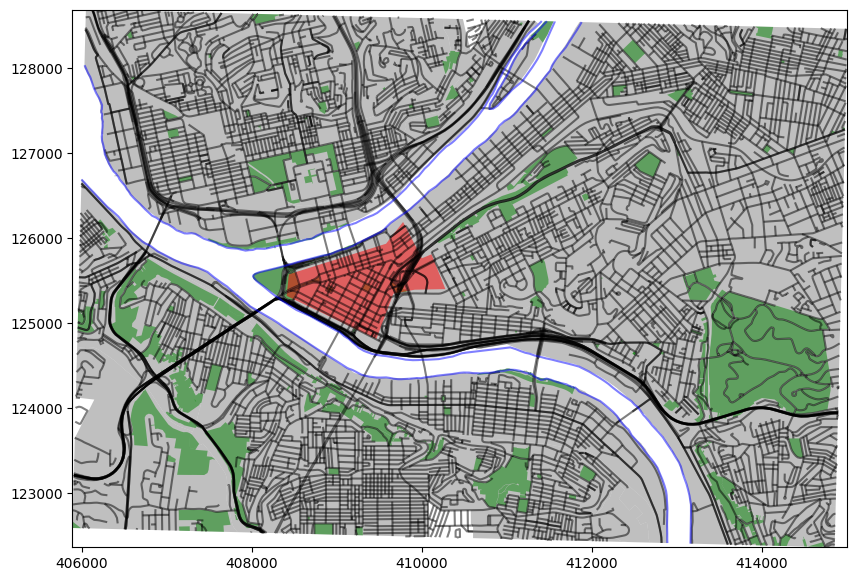

In [22]:
neighbor_gdf, parks_gdf, roads_gdf, water_gdf, downtown_gdf, downtown_surrounds_gdf = load_pgh_shp_files(EPSG_dict)

#plot 5 shapefiles, zooming to downtown_gdf
fig, ax = plt.subplots(figsize=(10,10))
neighbor_gdf.plot(ax=ax, color='grey', alpha=0.5)
parks_gdf.plot(ax=ax, color='green', alpha=0.5)
roads_gdf.plot(ax=ax, color='black', alpha=0.5)
water_gdf.plot(ax=ax, color='blue', alpha=0.5)
downtown_gdf.plot(ax=ax, color='red', alpha=0.5)

# zoom to bounds of downtown_surrounds_gdf
ax.set_xlim(downtown_surrounds_gdf.total_bounds[0], downtown_surrounds_gdf.total_bounds[2])
ax.set_ylim(downtown_surrounds_gdf.total_bounds[1], downtown_surrounds_gdf.total_bounds[3])


/Users/coltonlapp/Dropbox/My Mac (Coltons-MacBook-Pro.local)/Desktop/SCHOOL/Year2_Spring/IndepStudyProject/PGHComputerVision/myenv/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


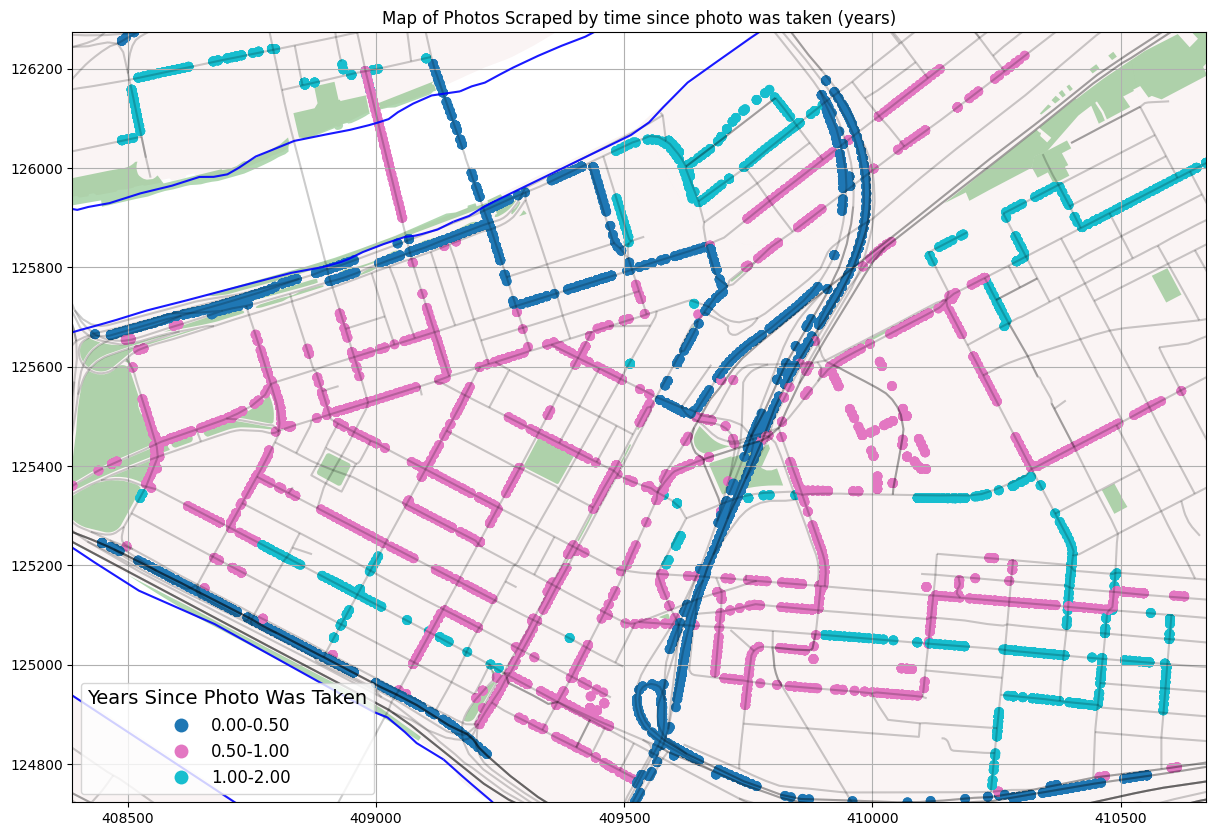

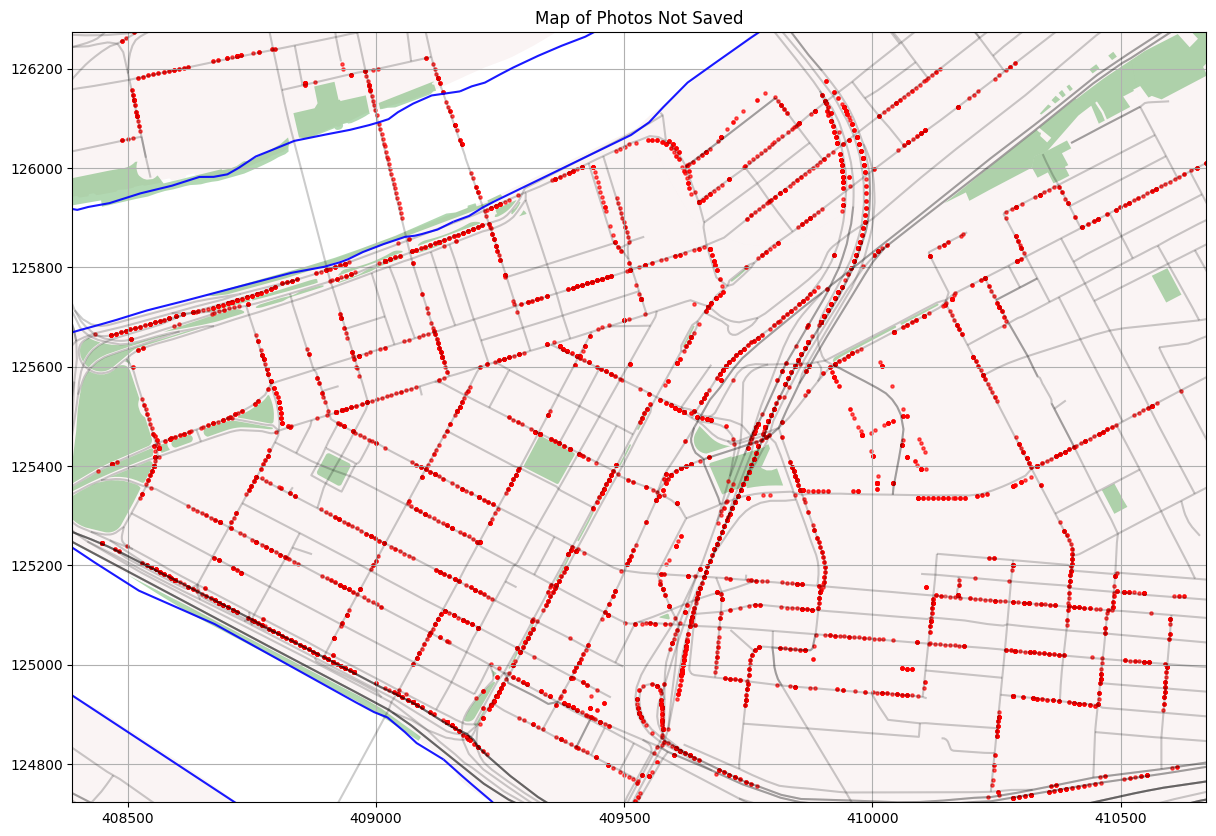

In [23]:
for gdf, title in zip( [images_gdf_merged, not_saved], ['Map of Photos Scraped by time since photo was taken (years)', 'Map of Photos Not Saved']):


    fig, ax = plt.subplots(figsize=(20, 10))

    # Plot the shapefiles
    neighbor_gdf.plot(ax=ax, color='brown', alpha=0.05)
    parks_gdf.plot(ax=ax, color='green', alpha=0.3)
    roads_gdf.plot(ax=ax, color='black', alpha=0.2, linewidth=1.5)
    water_gdf.plot(ax=ax, color='blue', alpha=0.9)

    if title == 'Map of Photos Scraped by time since photo was taken (years)':
        # Remove NaN values from the 'years_since_today' column
        images_gdf_dropped = images_gdf.dropna(subset=['years_since_today'])
        bin_edges = [0, 0.5, 1, 2]
        bin_labels = [f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}' for i in range(len(bin_edges)-1)]
        bins = pd.cut(images_gdf_dropped['years_since_today'], bins=bin_edges, labels=bin_labels, include_lowest=True)
        images_gdf_dropped['years_bins'] = bins
        cmap = plt.get_cmap('tab10', 4)  # 'tab10' is a colormap with 10 distinct colors, we use the first 4

        images_gdf_dropped.plot(column='years_bins', cmap=cmap, legend=True,
                                legend_kwds={'title': 'Years Since Photo Was Taken',
                                              'fontsize': 12,
                                              'loc' : 'lower left',
                                              'title_fontsize':14}, ax=ax)


    elif title == 'Map of Photos Not Saved':
        # plot not saved with red box
        not_saved.plot(ax=ax, color='red', alpha=0.4, markersize=5)

    # Zoom to the extent of the points in 'images_gdf'
    minx, miny, maxx, maxy = images_gdf.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # Add grid, legend, and title
    ax.set_title(title)
    ax.grid(True)





    # Show the plot
    plt.show()


In [24]:
# count number of points from photos gdf that are in downtown polygon
downtown_images_gdf = gpd.clip(images_gdf_merged, downtown_gdf)
downtown_images_gdf = downtown_images_gdf.dropna(subset=['geometry'])
print(f"Number of photos in downtown: {len(downtown_images_gdf)}")

downtown_images_gdf.head()

Number of photos in downtown: 4242


,segment_id,filename,image_panoid,date,query_counter,lat,lon,geometry,years_since_today,name,length,bearing
23538,684842474-684842485,img_684842474-684842485_h1_016.png,kZ_z5uRYioemWEf6Vp3w2w,2023-12-01,39.0,40.441075,-79.992610,POINT (409760.864 125413.759),0.30,None,122.110,91.2
2134,104572699-104573441,img_104572699-104573441_h0_004.png,ZiqppgAxP4ip184aU7A_7Q,2022-10-01,20.0,40.439209,-79.994567,POINT (409589.664 125210.800),1.47,Sixth Avenue,117.064,199.9
2135,104572699-104573441,img_104572699-104573441_h1_005.png,ZiqppgAxP4ip184aU7A_7Q,2022-10-01,21.0,40.439209,-79.994567,POINT (409589.664 125210.800),1.47,Sixth Avenue,117.064,199.9
2119,104572699-104573441,img_104572699-104573441_h1_003.png,v240jYlNDJUxJnT_1s5D2A,2022-10-01,5.0,40.439474,-79.994401,POINT (409604.444 125239.857),1.47,Sixth Avenue,117.064,199.9
2118,104572699-104573441,img_104572699-104573441_h0_002.png,v240jYlNDJUxJnT_1s5D2A,2022-10-01,4.0,40.439474,-79.994401,POINT (409604.444 125239.857),1.47,Sixth Avenue,117.064,199.9


In [25]:
# how many pics have NA name?
print(f"Number of photos with NA name: {len(downtown_images_gdf[downtown_images_gdf['name'].isna()])}")

# change nan to "NA" string
downtown_images_gdf['name'].fillna('NA', inplace=True)

# for any list in "name" column, convert to string
downtown_images_gdf['name'] = downtown_images_gdf['name'].apply(lambda x: x if type(x) != list else ', '.join(x) )

Number of photos with NA name: 577


/var/folders/np/9tdxr2056n39qzb1mpdsjrtc0000gn/T/ipykernel_19588/644442057.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  downtown_images_gdf['name'].fillna('NA', inplace=True)


In [26]:
# in downtown pics, remove pics corresponding to certain street names, ignoring case
street_names = ['Crosstown Boulevard', "Veteran's Bridge", "Boulevard of the Allies"]
street_names = street_names + ['Bigelow Boulevard', 'Bedford Avenue']

for name in street_names:
    # how many pics to remove? print
    print(f"Number of photos with {name}: { downtown_images_gdf['name'].str.contains(name, case=False).sum()}")
    downtown_images_gdf = downtown_images_gdf[~downtown_images_gdf['name'].str.contains(name, case=False)]

Number of photos with Crosstown Boulevard: 118
Number of photos with Veteran's Bridge: 0
Number of photos with Boulevard of the Allies: 204
Number of photos with Bigelow Boulevard: 144
Number of photos with Bedford Avenue: 88


Text(0.5, 1.0, 'Map of Photos in Downtown Pittsburgh After Clipping')

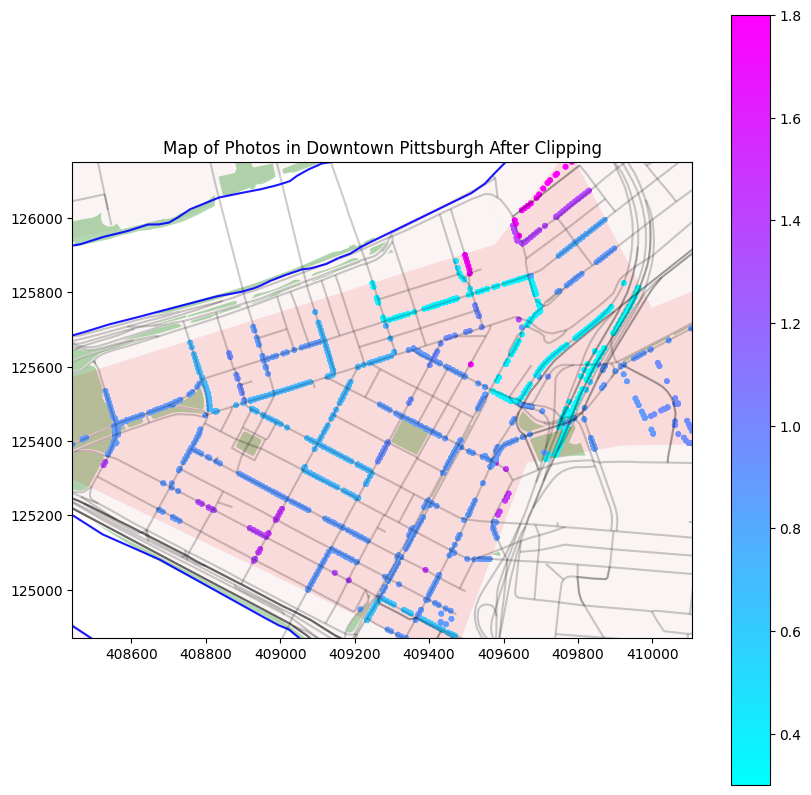

In [27]:
# plot the downtown photos along with baselayers
fig, ax = plt.subplots(figsize=(10,10))

# Plot the shapefiles
neighbor_gdf.plot(ax=ax, color='brown', alpha=0.05)
parks_gdf.plot(ax=ax, color='green', alpha=0.3)
roads_gdf.plot(ax=ax, color='black', alpha=0.2, linewidth=1.5)
water_gdf.plot(ax=ax, color='blue', alpha=0.9)
downtown_gdf.plot(ax=ax, color='red', alpha=0.1)

# Plot the points with color equaling the year of the "date" column
downtown_images_gdf.plot(ax=ax, column='years_since_today', cmap='cool', legend=True, markersize=10)

# zoom to bounds of downtown_images_gdf
ax.set_xlim(downtown_images_gdf.total_bounds[0], downtown_images_gdf.total_bounds[2])
ax.set_ylim(downtown_images_gdf.total_bounds[1], downtown_images_gdf.total_bounds[3])

# Set title
ax.set_title('Map of Photos in Downtown Pittsburgh After Clipping')




# Copy only downtown photos into new dir

In [28]:
new_dir = os.path.join(  data_root, 'GSV', 'Res_640', 'in_downtown')

# for each filename in downtown_images_gdf, copy the file to new_dir
for filename in downtown_images_gdf['filename']:
    old_path = os.path.join(  data_root, 'GSV', 'Res_640', 'PittsburghDowntown_2024-03-20', filename)
    new_path = os.path.join(new_dir, filename)
    #os.system(f'cp {old_path} {new_path}')

In [30]:
# save df 
csv_path = os.path.join(data_root, 'GSV', 'Res_640', 'in_downtown', 'downtown_pics_df.csv')
downtown_images_gdf.to_csv(csv_path, index=False)